# Flight Cancellation Prediction
Which airline should you fly on to avoid significant delays?

[Dataset](https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
data = pd.read_csv('flights.csv', nrows= 300000) 
data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2015,1,20,2,WN,651,N7734H,PIT,ATL,1615,1625.0,10.0,6.0,1631.0,115,95.0,81.0,526,1752.0,8.0,1810,1800.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
299996,2015,1,20,2,AA,65,N3CSAA,JFK,DFW,1615,1610.0,-5.0,22.0,1632.0,256,238.0,208.0,1391,1900.0,8.0,1931,1908.0,-23.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
299997,2015,1,20,2,AA,165,N3LNAA,BOS,LAX,1615,1614.0,-1.0,13.0,1627.0,394,375.0,357.0,2611,1924.0,5.0,1949,1929.0,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
299998,2015,1,20,2,AA,103,N437AA,MSY,DFW,1615,1615.0,0.0,12.0,1627.0,103,103.0,78.0,447,1745.0,13.0,1758,1758.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 300000 non-null  int64  
 1   MONTH                300000 non-null  int64  
 2   DAY                  300000 non-null  int64  
 3   DAY_OF_WEEK          300000 non-null  int64  
 4   AIRLINE              300000 non-null  object 
 5   FLIGHT_NUMBER        300000 non-null  int64  
 6   TAIL_NUMBER          299505 non-null  object 
 7   ORIGIN_AIRPORT       300000 non-null  object 
 8   DESTINATION_AIRPORT  300000 non-null  object 
 9   SCHEDULED_DEPARTURE  300000 non-null  int64  
 10  DEPARTURE_TIME       294561 non-null  float64
 11  DEPARTURE_DELAY      294561 non-null  float64
 12  TAXI_OUT             294390 non-null  float64
 13  WHEELS_OFF           294390 non-null  float64
 14  SCHEDULED_TIME       300000 non-null  int64  
 15  ELAPSED_TIME     

In [5]:
data.CANCELLED.value_counts()

0    294314
1      5686
Name: CANCELLED, dtype: int64

# Preprocessing

In [6]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix = prefix)
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(column, axis = 1)
    return df

In [7]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Remove columns with more than 25% missing values
    missing_columns = df.loc[:, df.isna().mean() >= 0.25].columns
    df = df.drop(missing_columns, axis = 1)
    
    # Drop unneeded columns
    df = df.drop(['YEAR', 'MONTH', 'FLIGHT_NUMBER', 'TAIL_NUMBER'], axis = 1)
    
    # One-hot encode nominal feature columns
    df = onehot_encode(
        df,
        column_dict = {
            'AIRLINE': 'AL',
            'ORIGIN_AIRPORT': 'OA',
            'DESTINATION_AIRPORT': 'DA'
        }
    )
    
    # Fill remaining missing values with column means
    remaining_na_columns = df.loc[:, df.isna().sum() > 0].columns
    for column in remaining_na_columns:
        df[column] = df[column].fillna(df[column].mean())
    
    # Split df into X and y
    y = df['CANCELLED'].copy()
    X = df.drop('CANCELLED', axis = 1).copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 1)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
   
    # Handling unmbalance label by oversmapling method
    oversampler = RandomOverSampler(random_state = 1)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

# After Preprocessing

In [9]:
X_train

,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,AL_AA,AL_AS,AL_B6,AL_DL,AL_EV,AL_F9,AL_HA,AL_MQ,AL_NK,AL_OO,AL_UA,AL_US,AL_VX,AL_WN,OA_ABE,OA_ABI,OA_ABQ,OA_ABR,OA_ABY,OA_ACT,OA_ACV,OA_ACY,OA_ADK,OA_ADQ,OA_AEX,OA_AGS,OA_ALB,OA_ALO,OA_AMA,OA_ANC,OA_APN,OA_ASE,OA_ATL,OA_ATW,OA_AUS,OA_AVL,OA_AVP,OA_AZO,OA_BDL,OA_BET,OA_BFL,OA_BHM,OA_BIL,OA_BIS,OA_BJI,OA_BLI,OA_BMI,OA_BNA,OA_BOI,OA_BOS,OA_BPT,OA_BQK,OA_BQN,OA_BRD,OA_BRO,OA_BRW,OA_BTM,OA_BTR,OA_BTV,OA_BUF,OA_BUR,OA_BWI,OA_BZN,OA_CAE,OA_CAK,OA_CDC,OA_CDV,OA_CEC,OA_CHA,OA_CHO,OA_CHS,OA_CID,OA_CIU,OA_CLD,OA_CLE,OA_CLL,OA_CLT,OA_CMH,OA_CMI,OA_CMX,OA_CNY,OA_COD,OA_COS,OA_COU,OA_CPR,OA_CRP,OA_CRW,OA_CSG,OA_CVG,OA_CWA,OA_DAB,OA_DAL,OA_DAY,OA_DBQ,OA_DCA,OA_DEN,OA_DFW,OA_DHN,OA_DIK,OA_DLH,OA_DRO,OA_DSM,OA_DTW,OA_DVL,OA_EAU,OA_ECP,OA_EGE,OA_EKO,OA_ELM,OA_ELP,OA_ERI,OA_ESC,OA_EUG,OA_EVV,OA_EWN,OA_EWR,OA_EYW,OA_FAI,OA_FAR,OA_FAT,OA_FAY,OA_FCA,OA_FLG,OA_FLL,OA_FNT,OA_FSD,OA_FSM,OA_FWA,OA_GCC,OA_GCK,OA_GEG,OA_GFK,OA_GGG,OA_GJT,OA_GNV,OA_GPT,OA_GRB,OA_GRI,OA_GRK,OA_GRR,OA_GSO,OA_GSP,OA_GTF,OA_GTR,OA_GUC,OA_GUM,OA_HDN,OA_HIB,OA_HLN,OA_HNL,OA_HOB,OA_HOU,OA_HPN,OA_HRL,OA_HSV,OA_HYS,OA_IAD,OA_IAG,OA_IAH,OA_ICT,OA_IDA,OA_ILG,OA_ILM,OA_IMT,OA_IND,OA_INL,OA_ISN,OA_ISP,OA_ITO,OA_JAC,OA_JAN,OA_JAX,OA_JFK,OA_JLN,OA_JMS,OA_JNU,OA_KOA,OA_KTN,OA_LAN,OA_LAR,OA_LAS,OA_LAW,OA_LAX,OA_LBB,OA_LBE,OA_LCH,OA_LEX,OA_LFT,OA_LGA,OA_LGB,OA_LIH,OA_LIT,OA_LNK,OA_LRD,OA_LSE,OA_LWS,OA_MAF,OA_MBS,OA_MCI,OA_MCO,OA_MDT,OA_MDW,OA_MEI,OA_MEM,OA_MFE,OA_MFR,OA_MGM,OA_MHK,OA_MHT,OA_MIA,OA_MKE,OA_MKG,OA_MLB,OA_MLI,OA_MLU,OA_MMH,OA_MOB,OA_MOT,OA_MQT,OA_MRY,OA_MSN,OA_MSO,OA_MSP,OA_MSY,OA_MTJ,OA_MYR,OA_OAJ,OA_OAK,OA_OGG,OA_OKC,OA_OMA,OA_OME,OA_ONT,OA_ORD,OA_ORF,OA_ORH,OA_OTH,OA_OTZ,OA_PAH,OA_PBG,OA_PBI,OA_PDX,OA_PHF,OA_PHL,OA_PHX,OA_PIA,OA_PIB,OA_PIH,OA_PIT,OA_PLN,OA_PNS,OA_PPG,OA_PSC,OA_PSE,OA_PSG,OA_PSP,OA_PUB,OA_PVD,OA_PWM,OA_RAP,OA_RDD,OA_RDM,OA_RDU,OA_RHI,OA_RIC,OA_RKS,OA_RNO,OA_ROA,OA_ROC,OA_ROW,OA_RST,OA_RSW,OA_SAF,OA_SAN,OA_SAT,OA_SAV,OA_SBA,OA_SBN,OA_SBP,OA_SCC,OA_SCE,OA_SDF,OA_SEA,OA_SFO,OA_SGF,OA_SGU,OA_SHV,OA_SIT,OA_SJC,OA_SJT,OA_SJU,OA_SLC,OA_SMF,OA_SMX,OA_SNA,OA_SPI,OA_SPS,OA_SRQ,OA_STC,OA_STL,OA_STT,OA_STX,OA_SUN,OA_SUX,OA_SWF,OA_SYR,OA_TLH,OA_TOL,OA_TPA,OA_TRI,OA_TTN,OA_TUL,OA_TUS,OA_TVC,OA_TWF,OA_TXK,OA_TYR,OA_TYS,OA_UST,OA_VEL,OA_VLD,OA_VPS,OA_WRG,OA_XNA,OA_YAK,OA_YUM,DA_ABE,DA_ABI,DA_ABQ,DA_ABR,DA_ABY,DA_ACT,DA_ACV,DA_ACY,DA_ADK,DA_ADQ,DA_AEX,DA_AGS,DA_ALB,DA_ALO,DA_AMA,DA_ANC,DA_APN,DA_ASE,DA_ATL,DA_ATW,DA_AUS,DA_AVL,DA_AVP,DA_AZO,DA_BDL,DA_BET,DA_BFL,DA_BHM,DA_BIL,DA_BIS,DA_BJI,DA_BLI,DA_BMI,DA_BNA,DA_BOI,DA_BOS,DA_BPT,DA_BQK,DA_BQN,DA_BRD,DA_BRO,DA_BRW,DA_BTM,DA_BTR,DA_BTV,DA_BUF,DA_BUR,DA_BWI,DA_BZN,DA_CAE,DA_CAK,DA_CDC,DA_CDV,DA_CEC,DA_CHA,DA_CHO,DA_CHS,DA_CID,DA_CIU,DA_CLD,DA_CLE,DA_CLL,DA_CLT,DA_CMH,DA_CMI,DA_CMX,DA_CNY,DA_COD,DA_COS,DA_COU,DA_CPR,DA_CRP,DA_CRW,DA_CSG,DA_CVG,DA_CWA,DA_DAB,DA_DAL,DA_DAY,DA_DBQ,DA_DCA,DA_DEN,DA_DFW,DA_DHN,DA_DIK,DA_DLH,DA_DRO,DA_DSM,DA_DTW,DA_DVL,DA_EAU,DA_ECP,DA_EGE,DA_EKO,DA_ELM,DA_ELP,DA_ERI,DA_ESC,DA_EUG,DA_EVV,DA_EWN,DA_EWR,DA_EYW,DA_FAI,DA_FAR,DA_FAT,DA_FAY,DA_FCA,DA_FLG,DA_FLL,DA_FNT,DA_FSD,DA_FSM,DA_FWA,DA_GCC,DA_GCK,DA_GEG,DA_GFK,DA_GGG,DA_GJT,DA_GNV,DA_GPT,DA_GRB,DA_GRI,DA_GRK,DA_GRR,DA_GSO,DA_GSP,DA_GTF,DA_GTR,DA_GUC,DA_GUM,DA_HDN,DA_HIB,DA_HLN,DA_HNL,DA_HOB,DA_HOU,DA_HPN,DA_HRL,DA_HSV,DA_HYS,DA_IAD,DA_IAG,DA_IAH,DA_ICT,DA_IDA,DA_ILG,DA_ILM,DA_IMT,DA_IND,DA_INL,DA_ISN,DA_ISP,DA_ITO,DA_JAC,DA_JAN,DA_JAX,DA_JFK,DA_JLN,DA_JMS,DA_JNU,DA_KOA,DA_KTN,DA_LAN,DA_LAR,DA_LAS,DA_LAW,DA_LAX,DA_LBB,DA_LBE,DA_LCH,DA_LEX,DA_LFT,DA_LGA,DA_LGB,DA_LIH,DA_LIT,DA_LNK,DA_LRD,DA_LSE,DA_LWS,DA_MAF,DA_MBS,DA_MCI,DA_MCO,DA_MDT,DA_MDW,DA_MEI,DA_MEM,DA_MFE,DA_MFR,DA_MGM,DA_MHK,DA_MHT,DA_MIA,DA_MKE,DA_MKG,DA_MLB,DA_MLI,DA_MLU,DA_MMH,DA_MOB,DA_MOT,DA_MQT,DA_MRY,DA_MSN,DA_MSO,DA_MSP,DA_MSY,DA_MTJ,DA_MYR,DA_OAJ,DA_OAK,DA_OGG,DA_OKC,DA_OMA,DA_OME,

In [10]:
X_train.isnull().sum().sum()

0

In [11]:
y_train.value_counts()

0    206037
1    206037
Name: CANCELLED, dtype: int64

# Training

In [12]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# Results

In [13]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["NOT CANCELLED", "CANCELLED"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["NOT CANCELLED", "CANCELLED"])
    plt.yticks(np.arange(2) + 0.5, ["NOT CANCELLED", "CANCELLED"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

Test Accuracy: 83.10%


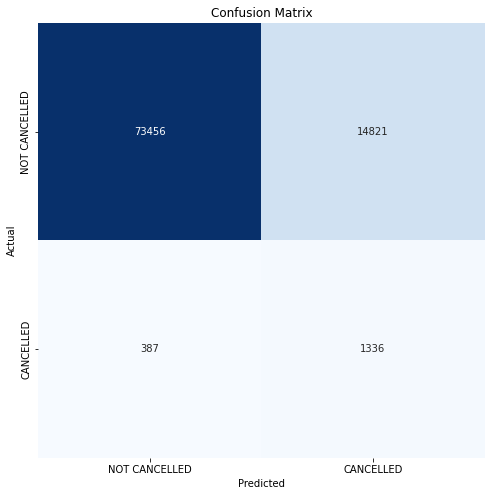

Classification Report:
----------------------
                precision    recall  f1-score   support

NOT CANCELLED       0.99      0.83      0.91     88277
    CANCELLED       0.08      0.78      0.15      1723

     accuracy                           0.83     90000
    macro avg       0.54      0.80      0.53     90000
 weighted avg       0.98      0.83      0.89     90000



In [14]:
evaluate_model(model, X_test, y_test)